# Competition: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

## [Short Description](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/description) (and Disclaimer)

This is a “getting started” competition, where we use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. I used the [Time Series course on Kaggle](https://www.kaggle.com/learn/time-series) to help me get started, and a lot of the code in this notebook is from that course.rse are inspired by winning solutions from past Kaggle time series forecasting competitions.

## [Evaluation](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/evaluation)
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
$[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]$
where:

𝑛 is the total number of instances,  
𝑦̂ 𝑖 is the predicted value of the target for instance (i),  
𝑦𝑖 is the actual value of the target for instance (i), and,  
log is the natural logarithm.

## [Data](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

### Training data: train.csv

* The training data, comprising time series of features **store_nbr**, **family**, and **onpromotion** as well as the target **sales**.
* **store_nbr** identifies the store at which the products are sold.
* **family** identifies the type of product sold.
* **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.


### Test data: test.csv

* The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file. 
* The dates in the test data are for the 15 days after the last date in the training data.


### Submission file: sample_submission.csv
A sample submission file in the correct format.

### Additional information
#### 1. Store metadata: stores.csv
  * Store metadata, including **city**, **state**, **type**, and **cluster**.
  * **cluster** is a grouping of similar stores.

#### 2. Daily oil price: oil.csv 
Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### 3. Holidays and Events, with metadata: holidays_events.csv
  * NOTE: Pay special attention to the **transferred** column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
  * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


### Additional Notes
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Preliminaries

## Dependencies

In [2]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex4 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

## Competition Data

In [3]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

# Train data: train.csv
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

# Holidays and Events, with metadata
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

# Test data: test.csv
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# EDA

[WIP]: Going to expand this section in upcoming weeks

In [4]:
store_sales.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

### Indices

#### Date

**Total duration of data:**

In [5]:
print(f"Training data: {store_sales.index.get_level_values(2).min()} -- {store_sales.index.get_level_values(2).max()}")
print(f"Test data: {df_test.index.get_level_values(2).min()} -- {df_test.index.get_level_values(2).max()}")


Training data: 2013-01-01 -- 2017-08-15
Test data: 2017-08-16 -- 2017-08-31


This amounts to slightly more than 4.5 years (55 months) of training data, followed by the next 15 days to test our model on.

#### Family

The products in the training data belong to different families.

In [6]:
print(f"Total number of families: {len(store_sales.index.unique(level=1))}")

print(f"First 5 families (in alphabetical order): {[x.capitalize() for x in store_sales.index.unique(level=1)[:5]]}")

print(f"Last 5 families (in alphabetical order): {[x.capitalize() for x in store_sales.index.unique(level=1)[-5:]]}")

Total number of families: 33
First 5 families (in alphabetical order): ['Automotive', 'Baby care', 'Beauty', 'Beverages', 'Books']
Last 5 families (in alphabetical order): ['Poultry', 'Prepared foods', 'Produce', 'School and office supplies', 'Seafood']


# Modelling

As we learnt in the [Time Series course on Kaggle](https://www.kaggle.com/learn/time-series), there are 2 essential components of a time-series:
* **Time dependence** that leads to two key featues: [Trends](https://www.kaggle.com/code/ryanholbrook/trend) and [Seasonality](https://www.kaggle.com/code/ryanholbrook/seasonality)
* **Serial depencdence** that leads to [cycles](https://www.kaggle.com/code/ryanholbrook/time-series-as-features), and can be explored through lag features.

Each of these features are worth exploring one-by-one in detail. We are goinig to follow the lead of the tutorial in realising that a single machine learning algorithm might not be best-suited to capture all these independent components. While regression algorithms are better for detrending/deseasonalising, [serial dependence is best explored through **decision trees**](https://www.kaggle.com/code/ryanholbrook/time-series-as-features). Hence, getting the best of both worlds, we are going to explore [Hybrid models](https://www.kaggle.com/code/ryanholbrook/hybrid-models) that employ a combination of the above algorithms.

## Trends

As defined in [Time Series course on Kaggle](https://www.kaggle.com/code/ryanholbrook/trend) course, the **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance.

The training set has information that drills down to different levels of detail, eg, store number, product family, etc. At the highest-level, we start looking at trends in the time-dependence of average sales.

In [7]:
average_sales = store_sales.groupby('date').mean()['sales']
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

Calculating a year-long moving average smoothens out short-term fluctuations in the series retaining only long-term changes. With this, we see a year-on-year growth in the average sales.

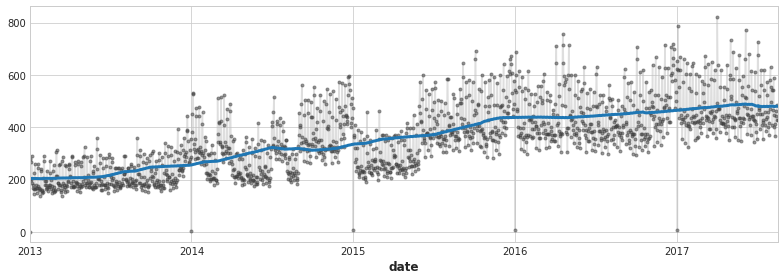

In [8]:
# moving average plot of average_sales estimating the trend

trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### First prediction: based on trend

At this point, we attempt to make our first prediction, just using the trend of first, the average sales, and then each family at a time. As we have already seen in the previous plot, the average sales show a year-on-year growth which can be approximated using a linear regression. The polynomial we fit to the sales is our choice, and we will use orders 1 and 3 to see their effects on the prediction. We use the `DeterministicProcess` function to create a feature set for a trend model.

#### Polynomial order: 1

In [9]:
# the target

y = average_sales.copy()
y.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

In [10]:
# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend): linear trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


As is standard for evaluating machine learning models, we split our training data into a training set and a validation set. We use the training set to train the model and evaluate its performance on the validation set. In this case, we choose our validation set to be the same size as the actual test set (15 days), and we choose it to be the last 15 days of the original training set. This is to resemble the test set which is 15 days from the end of the training data. 

**[Evaluation](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/evaluation):** We use the same metric for evaluating performance on the validation set as will be used for the actual test set, namely, the Root Mean Squared Logarithmic Error, calculated as:

$[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]$

where:

𝑛 is the total number of instances,  
𝑦̂ 𝑖 is the predicted value of the target for instance (i),  
𝑦𝑖 is the actual value of the target for instance (i), and,  
log is the natural logarithm.

Training RMSLE: 0.32472
Validation RMSLE: 0.18144


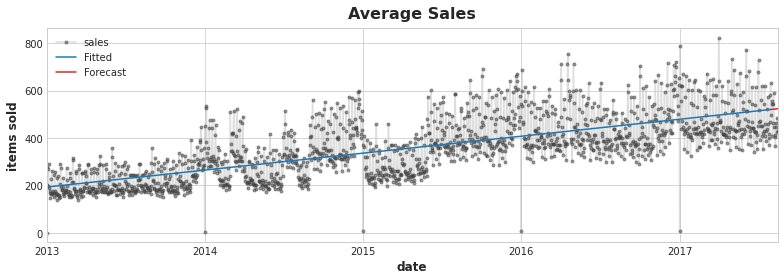

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

#### Polynomial order: 3

In [12]:
# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


Training RMSLE: 0.32328
Validation RMSLE: 0.14174


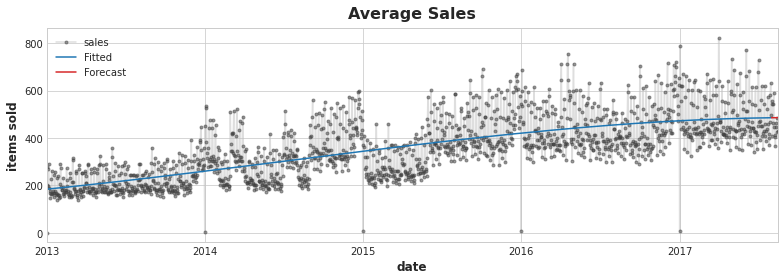

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

We see that the cubic polynomial performs about the same on the training data, but generalises better to the validation set. We will retain the cubic trend for the remainder of this analyses.

#### Average sales vs Per Item sales

In practise, each family of items can have its own trends; and the resulting trend is expected to be their combination. We use this information to redefine our target sales in terms of the data **and family**, instead of averaging over the latter as previously. From there on, we follow the exact procedure with `DeterministicProcess` as we did for the `average_sales` in order to compute the resultant cubic trend of each family; and evaluate our performance on the validation set.

In [14]:
y = store_sales.unstack(['store_nbr', 'family'])  # the target
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   

                                                    ...                        \
store_nbr                                           ...         9               
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2013-01-01         0.0      0.0    0.0    0.000000  ...       0.0    0.000000   
2013-01-02         0.0   1060.0  579.0  164.069000  ...       0.0  374.531006   
2013-01-03         0.0    836.0  453.0  151.582001  ...       0.0  400.863007   
2013-01-04         0.0    827.0  460.0  131.410995  ...       0.0  310.877991   
2013-01-05         0.0    811.0  464.0  118.612999  ...       0.0  447.684998   

                                                                           \
store_nbr                                                                   
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2013-01-01           0.0          0.0                     0.0    0.000000   
2013-01-02         482.0          0.0                     0.0  651.291992   
2013-01-03         372.0          0.0                     0.0  509.496002   
2013-01-04         324.0          0.0                     0.0  332.671997   
2013-01-05         461.0          0.0                     0.0  510.919006   

                                                                         
store_nbr                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                     
2013-01-01            0.0     0.0                        0.0   0.000000  
2013-01-02           83.0     0.0                        0.0  29.214001  
2013-01-03           66.0     0.0                        0.0  25.000000  
2013-01-04           57.0     0.0                        0.0  11.000000  
2013-01-05           84.0     0.0                        0.0  28.361000  

[5 rows x 1782 columns]

In [15]:
# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 1.08942
Validation RMSLE: 0.59417


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   3.989250       0.0  3.531821  2196.628603  0.716912   343.640481   
2017-08-02   3.987273       0.0  3.534058  2196.550189  0.718472   343.374526   
2017-08-03   3.985285       0.0  3.536296  2196.469286  0.720033   343.107744   
2017-08-04   3.983288       0.0  3.538537  2196.385892  0.721597   342.840136   
2017-08-05   3.981282       0.0  3.540779  2196.300004  0.723162   342.571700   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   14.867376  652.084491  723.399901  125.146642  ...  3.572239   
2017-08-02   14.857873  651.978731  723.315812  125.079406  ...  3.567129   
2017-08-03   14.848331  651.872595  723.231415  125.011949  ...  3.561989   
2017-08-04   14.838750  651.766082  723.146710  124.944271  ...  3.556819   
2017-08-05   14.829128  651.659192  723.061697  124.876371  ...  3.551620   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  400.943405    450.827401     8.332957               11.246038   
2017-08-02  400.976549    450.483202     8.338341               11.239880   
2017-08-03  401.009700    450.137935     8.343720               11.233688   
2017-08-04  401.042858    449.791600     8.349094               11.227461   
2017-08-05  401.076023    449.444195     8.354462               11.221199   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-01  469.952945     130.385421  1632.064882                   2.883387   
2017-08-02  470.156275     130.457848  1631.080944                   2.857556   
2017-08-03  470.360760     130.530316  1630.091322                   2.831655   
2017-08-04  470.566403     130.602826  1629.096009                   2.805684   
2017-08-05  470.773206     130.675376  1628.094999                   2.779641   

                       
store_nbr              
family        SEAFOOD  
date                   
2017-08-01  16.740531  
2017-08-02  16.732058  
2017-08-03  16.723550  
2017-08-04  16.715008  
2017-08-05  16.706430  

[5 rows x 1782 columns]

Our model seems to generalise well to our validation set. We will use this model to make our first submission and set a baseline for future revisions of our model.

### First submission: based on trends

In [17]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2017-08-16,1.0,1685.0,2839225.0,4.784094e+09
2017-08-17,1.0,1686.0,2842596.0,4.792617e+09
2017-08-18,1.0,1687.0,2845969.0,4.801150e+09
2017-08-19,1.0,1688.0,2849344.0,4.809693e+09
2017-08-20,1.0,1689.0,2852721.0,4.818246e+09


In [18]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend.csv', index=False)

y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     3.958569
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.565596
                     BEVERAGES   3000891  2195.189935
                     BOOKS       3000892     0.740510

### [Public Score: 0.63608](https://www.kaggle.com/code/abhirupghosh184098/store-sales-time-series-forecasting?scriptVersionId=111635179)

With the above submission, which only uses trends to make a prediction, we were able to get a RMSLE score of 0.63608. We will slowly improve on the model in iterations.

#### Only 2017 data

One of the reasons we might be doing so much better in the validation set than the training set using just information about trends is that the training set has > 50 months of data points, while the validation and test sets are just a fortnight. It might be worth checking out if trends in the more recent past might be better at predicting the trends of the test period, so as to not be biased by trends which are > 4 years old.

In [19]:
# target sales only in 2017

y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   

                    
store_nbr           
family     SEAFOOD  
date                
2017-01-01     0.0  
2017-01-02    23.0  
2017-01-03    14.0  
2017-01-04     0.0  
2017-01-05    17.0  

[5 rows x 1782 columns]

In [20]:
# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2017-01-01,1.0,1.0,1.0,1.0
2017-01-02,1.0,2.0,4.0,8.0
2017-01-03,1.0,3.0,9.0,27.0
2017-01-04,1.0,4.0,16.0,64.0
2017-01-05,1.0,5.0,25.0,125.0


In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 0.62841
Validation RMSLE: 0.56709


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   5.349450       0.0  3.344444  2124.133887  0.092436   338.766558   
2017-08-02   5.393372       0.0  3.340316  2119.957001  0.081210   338.736613   
2017-08-03   5.438187       0.0  3.335902  2115.658091  0.069748   338.716315   
2017-08-04   5.483904       0.0  3.331199  2111.235822  0.058048   338.705777   
2017-08-05   5.530532       0.0  3.326201  2106.688860  0.046107   338.705109   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   14.902556  645.655768  672.191072  137.821375  ...  2.974365   
2017-08-02   14.858090  644.919083  671.439019  138.216361  ...  2.964886   
2017-08-03   14.812717  644.165706  670.690078  138.623278  ...  2.955491   
2017-08-04   14.766429  643.395464  669.944353  139.042253  ...  2.946182   
2017-08-05   14.719221  642.608187  669.201944  139.473411  ...  2.936964   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  380.757536    393.289108     8.116384                6.445317   
2017-08-02  380.534249    390.608215     8.109137                6.344014   
2017-08-03  380.309941    387.881987     8.101568                6.242382   
2017-08-04  380.084599    385.110039     8.093675                6.140427   
2017-08-05  379.858211    382.291983     8.085454                6.038155   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-01  413.811796     102.347958  1585.752995                  10.281379   
2017-08-02  412.205319     101.846460  1582.088909                  10.531045   
2017-08-03  410.559099     101.340696  1578.336275                  10.785652   
2017-08-04  408.872733     100.830664  1574.494123                  11.045242   
2017-08-05  407.145821     100.316361  1570.561484                  11.309859   

                       
store_nbr              
family        SEAFOOD  
date                   
2017-08-01  14.092199  
2017-08-02  13.898313  
2017-08-03  13.701075  
2017-08-04  13.500466  
2017-08-05  13.296464  

[5 rows x 1782 columns]

Suddenly, our training and validation scores are a lot closer to each other. This comes in the form of a betterment of the training score and a worsening of the validation score. But what it really indicates is that the model generalises a lot better now. 

**We will now use this model to make predictions for the test score.**

In [22]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2017-08-16,1.0,228.0,51984.0,11852352.0
2017-08-17,1.0,229.0,52441.0,12008989.0
2017-08-18,1.0,230.0,52900.0,12167000.0
2017-08-19,1.0,231.0,53361.0,12326391.0
2017-08-20,1.0,232.0,53824.0,12487168.0


In [23]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend_2017.csv', index=False)

y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     6.105940
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.250720
                     BEVERAGES   3000891  2048.061053
                     BOOKS       3000892    -0.101825